In [1]:
import os
import datetime
import pandas as pd
import torch
import torch.nn as nn

from training_utils import training_loop, test_loop
from model import RNNLM
from data_utils import IndexVectorizer, TextDataset, simple_tokenizer

In [2]:
torch.__version__

'0.4.1'

In [5]:
# GPU variables
use_gpu = torch.cuda.is_available()
device_num = 0
device = torch.device(f"cuda:{device_num}" if use_gpu else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Text-related global variables
max_seq_len = 30
min_word_freq = 20

# File-writing variables
today = datetime.datetime.now().strftime('%Y-%m-%d')
working_directory = '/scratch/ly501/ml/'
data_directory = os.path.join(working_directory, 'data')
model_directory = os.path.join(working_directory, 'model')


train_file = os.path.join(data_directory, 'train.csv')
valid_file = os.path.join(data_directory, 'valid.csv')
test_file = os.path.join(data_directory, 'test.csv')

model_file_lm = os.path.join(model_directory, f'LM__{today}.json')
model_file_class = os.path.join(model_directory, f'CLASS__{today}.json')
for _dir in [working_directory, model_directory, data_directory]:
    os.makedirs(_dir, exist_ok=True)

In [7]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
valid= pd.read_csv(valid_file)

In [8]:
vectorizer = IndexVectorizer(max_words=None, min_frequency=min_word_freq, 
                             start_end_tokens=True, maxlen=max_seq_len)

# these can take a DF or a path to a csv
training_set = TextDataset(train, text_col='text',
                           vectorizer=vectorizer, 
                           tokenizer=simple_tokenizer)
test_set = TextDataset(test, text_col='text',
                       vectorizer=vectorizer, 
                       tokenizer=simple_tokenizer)
validation_set = TextDataset(valid, text_col='text',
                             vectorizer=vectorizer, 
                             tokenizer=simple_tokenizer)

In [8]:
len(training_set), len(validation_set), len(test_set)

(5000, 1000, 2000)

In [9]:
training_set[0]

(tensor([ 2,  4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16, 17, 18,  4,
         19, 20, 21, 22, 23,  4, 24,  1, 25,  1,  1,  1]),
 tensor([ 4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16, 17, 18,  4, 19,
         20, 21, 22, 23,  4, 24,  1, 25,  1,  1,  1,  0]))

In [10]:
print("Vocab size: {}".format(vectorizer.vocabulary_size))

Vocab size: 2389


In [11]:
device

device(type='cuda', index=0)

In [9]:
# Set Seed
if use_gpu: torch.cuda.manual_seed(303)
else: torch.manual_seed(303)

# set up Files to save stuff in
runtime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_file_lm = model_file_lm
    
# Model Hyper Parameters 
hidden_dim = 100
embedding_dim = 200
batch_size = 512
dropout = 0.2
lstm_layers = 1 # this is useless atm
lstm_bidirection = True

# Training
learning_rate = 1e-4
num_epochs = 300
display_epoch_freq = 10

# Build and initialize the model
lm = RNNLM(device, vectorizer.vocabulary_size, max_seq_len, embedding_dim, hidden_dim, batch_size, 
           dropout = dropout, 
           tie_weights = False, 
           num_layers = lstm_layers, 
           bidirectional = lstm_bidirection, 
           word2idx = vectorizer.word2idx,
           log_softmax = True)

if use_gpu:
    lm = lm.to(device)
lm.init_weights()

# Loss and Optimizer
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(lm.parameters(), lr=learning_rate)

In [13]:
# Train the model
history = training_loop(batch_size, num_epochs, display_epoch_freq, 
                        lm, loss, optimizer, device, 
                        training_set, validation_set, 
                        best_model_path=model_file_lm)

Epoch: 0000; Loss: 3.4016; Val-Loss 3.3998; Perplexity 30.0115; Val-Perplexity 29.9567
Sample: <START> review review going you. are and hands if sandwich here, pho there is some door. inside. decent will are are review live its pho <END> most sauce. almost live brisket
Epoch: 0010; Loss: 3.2698; Val-Loss 3.2507; Perplexity 26.3059; Val-Perplexity 25.8076
Sample: <START> now building it. was it. because located friendly brisket next my no (which brisket but if the be decent located fries. that best get as fries paying paid compare ever
Epoch: 0020; Loss: 3.0202; Val-Loss 2.9926; Perplexity 20.4945; Val-Perplexity 19.9380
Sample: <START> covered there most it. sauce. places food i there nothing i best and korean nice place are place review decent location which friendly place clean very most knew my for
Epoch: 0030; Loss: 2.6783; Val-Loss 2.6318; Perplexity 14.5609; Val-Perplexity 13.8989
Sample: <START> restaurant and beans because you. no what very staff would fries. a <UNK> hate with 

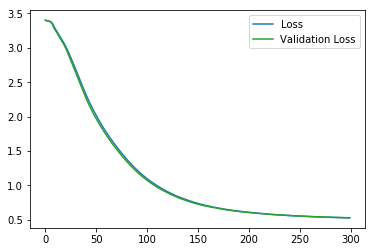

In [14]:
history.plot()

In [10]:
lm.load_state_dict(torch.load(model_file_lm))
test_loop(256, lm, loss, optimizer, test_set, device=device)

Evaluation Complete
Test set Loss: 0.5138191692531109
Test set Perplexity: 1.6716633843646285
Test set Accuracy: 0.0


## How does an LSTM work?
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [77]:
X = torch.LongTensor([[1,2,3,4,1,2,1], [1,2,3,4,5,1,2]])

In [80]:
X

tensor([[1, 2, 3, 4, 1, 2, 1],
        [1, 2, 3, 4, 5, 1, 2]])

In [78]:
embed = nn.Embedding(6, 100)

In [79]:
x_embed = embed(X)

In [81]:
lstm1 = nn.LSTM(100, 100, 
                 num_layers = 1, 
                 bidirectional = False,
                 batch_first = True)

In [83]:
x_embed.shape

torch.Size([2, 7, 100])

In [63]:
hidden = (torch.zeros(1,2,100), torch.zeros(1,2,100))

In [98]:
output, (h_n, c_n) = lstm1(x_embed, hidden)

In [99]:
# h1
h_n.shape

torch.Size([1, 2, 100])

In [100]:
# c0
c_n.shape

torch.Size([1, 2, 100])

In [103]:
# hidden
output.shape

torch.Size([2, 7, 100])

In [109]:
h_n.squeeze() == output[:,-1,:]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]], dtype=torch.uint8)